In [110]:
%load_ext autoreload 

import numpy as np
import os
import pandas as pd

from collections import defaultdict
from joblib import Parallel, delayed, pool
from multiprocessing import cpu_count
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.feature_selection import mutual_info_regression
from sklearn.manifold import Isomap, LocallyLinearEmbedding, TSNE
from sklearn.preprocessing import StandardScaler, RobustScaler
from umap import UMAP

from utils import load_dataset, TRIMS
N_CPU = cpu_count()
import warnings
warnings.filterwarnings("ignore")
%autoreload 2

plt.rcParams['font.size'] = 20

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
def evaluate_mi(method, X, y, n_neighbors_mi=50, create_embedding=True):
    '''
    method - dimensionality reduction method
    X- dataset
    y - target
    create_embedding: bool - if we need to create embedding form X
    '''
    if create_embedding:
        Z = method.fit_transform(X)
    else:
        Z = X.copy()
    mi_Z = mutual_info_regression(Z, y, discrete_features=False, n_neighbors=n_neighbors_mi, random_state=42)    
    return mi_Z.mean()

def normalize_features(X):
    return X / (np.linalg.norm(X,axis=-1)[:,None] + 1e-7)

In [112]:
intdims = np.load('./results/int_dim/MLE_intdim_MAX_Circle.npy', allow_pickle=True).item()

MOUSES = ['22', '23', '24', '25']
DAYS = [1,2,3]

config = {
    'dt':2500, # timewindow length
    'n_neighbors':200, # for UMAP
    'n_components': 7, #'intdim', # for UMAP
    'n_neighbors_mi': 15, 
    'dt_iterator':100,
    'dt_embedding': False # create separate embedding in timewindow
}

dt = config['dt']
dt_iterator = config['dt_iterator']
n_components = config['n_components']
n_neighbors = config['n_neighbors'] 
n_neighbors_mi = config['n_neighbors_mi']
dt_embedding = config['dt_embedding']

experiment_path = f'results/MI/experiment_dt-{dt}_ncomp-{n_components}_nn-{n_neighbors}_nnmi-{n_neighbors_mi}'
if dt_embedding:
    experiment_path += '_dt_embedding'

if not os.path.exists(experiment_path):
    os.makedirs(experiment_path)
else:
    print(experiment_path, 'already exists!')

np.save(os.path.join(experiment_path, 'config'), config)

results/MI/experiment_dt-2500_ncomp-7_nn-200_nnmi-15 already exists!


In [114]:
ls -la results/MI/experiment_dt-2500_ncomp-7_nn-200_nnmi-15

total 12
drwxr-xr-x 2 ibulygin users 4096 май 23 13:26 ./
drwxr-xr-x 3 ibulygin users 4096 май 23 13:26 ../
-rw-r--r-- 1 ibulygin users  398 май 23 13:28 config.npy


In [ ]:
scores_mi_all = defaultdict(dict)

for i, mouse in enumerate(MOUSES):
    for j, day in enumerate(DAYS):
        
        data, targets = load_dataset('data', mouse=mouse, day=day, track=track, trims=TRIMS[day][mouse])
        
        X = data['cadata'].copy() # [T,d]
        phi = targets['phi'].copy() # [T,1]
        
        X_n = RobustScaler().fit_transform(X) #normalize_features(X)
        T = int(X_n.shape[0])
        iterator = np.arange(0, T-dt, dt_iterator)
        
        if n_components == 'intdim':
            dim = intdims[mouse][day]
        elif isinstance(n_components, int):
            dim = n_components
        else:
            raise RuntimeError('Wrong `n_components` argument!')
        
        # dimensionality reduction
        method = UMAP(n_components=dim, 
                      n_neighbors=n_neighbors, 
                      n_jobs=1, 
                      random_state=42)
        
        if not dt_embedding:
            method.n_jobs = N_CPU//2
            X_n = method.fit_transform(X_n)

        scores_mi = Parallel(n_jobs=min(len(iterator),N_CPU//2),
                             verbose=0)(delayed(evaluate_mi)(None, 
                                                             X_n[i:i+dt,:], 
                                                             phi[i:i+dt], 
                                                             n_neighbors_mi,
                                                             create_embedding=dt_embedding)
                                        for i in tqdm_notebook(iterator))

        scores_mi = np.array(scores_mi)
        scores_mi_all[mouse][day] = scores_mi
        
        np.save(os.path.join(experiment_path, f'UMAP-phi_M{mouse}_D{day}_{track}'), scores_mi)
                

In [132]:
i = 10000
scores_mi_noise = evaluate_mi(None, 
                             X_n[i:i+dt,:], 
                             np.random.randn(*phi[i:i+dt].shape), 
                             n_neighbors_mi,
                             create_embedding=dt_embedding)

In [133]:
scores_mi_noise

0.0004025361368984142

In [ ]:
# scores_mi_all = defaultdict(dict)
# for i, mouse in enumerate(MOUSES):
#     for j, day in enumerate(DAYS):
#         scores_mi = np.load(os.path.join(experiment_path, f'UMAP-phi_M{mouse}_D{day}_{track}.npy'), allow_pickle=True)
#         scores_mi_all[mouse][day] = scores_mi

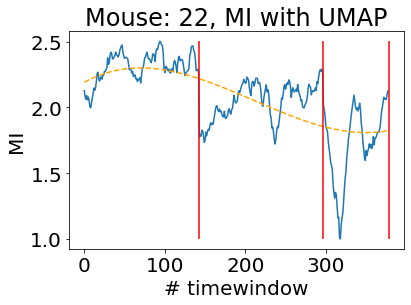

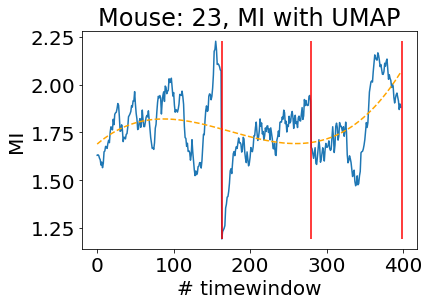

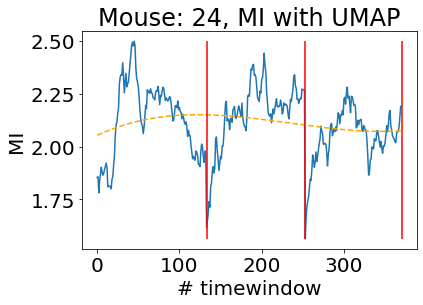

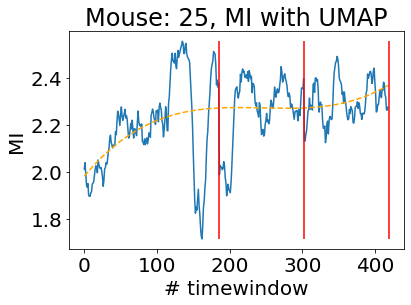

In [129]:
switch_times = defaultdict(list)
scores_mi_mouses = defaultdict(list)
for i, mouse in enumerate(MOUSES):
    for j, day in enumerate(DAYS):
        scores_mi = scores_mi_all[mouse][day] 
        scores_mi_mouses[mouse].append(scores_mi)
        switch_times[mouse].append(len(scores_mi))
    scores_mi_mouses[mouse] = np.concatenate(scores_mi_mouses[mouse])
    switch_times[mouse] = np.cumsum(switch_times[mouse])
    
    
    x = np.arange(len(scores_mi_mouses[mouse]))
    MI = scores_mi_mouses[mouse]
    z = np.polyfit(x, MI, deg=3)
    poly = np.poly1d(z)
    
    plt.figure()
    plt.plot(MI)
    plt.plot(poly(x), color='orange', linestyle='--')
    
    plt.vlines(switch_times[mouse], min(MI), max(MI), color='red')
    plt.title(f'Mouse: {mouse}, MI with UMAP')
    plt.ylabel('MI')
    plt.xlabel('# timewindow')
    plt.show()